<a href="https://colab.research.google.com/github/roxacarv/edulearn/blob/main/Edulearn_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Edulearn
##ML Clustering

#Importando as bibliotecas

In [1]:
#Importando as bibliotecas
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import warnings
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.style as style
import pandas as pd
import numpy as np

#Instalando a biblioteca biokit
Para visualização da matriz de correlação

In [2]:
#Instalando a biblioteca biokit
#A versão atual do biokit (0.4.6) não é compatível com o Windows 10, é necessário instalar a versão 0.4.2, neste caso. 
!pip install biokit=="0.4.2"

     |████████████████████████████████| 115 kB 36.3 MB/s 
     |████████████████████████████████| 47 kB 4.4 MB/s 
     |████████████████████████████████| 255 kB 55.3 MB/s 
     |████████████████████████████████| 202 kB 57.7 MB/s 
     |████████████████████████████████| 2.3 MB 49.6 MB/s 
     |████████████████████████████████| 47 kB 5.4 MB/s 
     |████████████████████████████████| 44 kB 2.6 MB/s 
     |████████████████████████████████| 144 kB 59.5 MB/s 
     |████████████████████████████████| 5.8 MB 46.8 MB/s 
     |████████████████████████████████| 251 kB 68.8 MB/s 
     |████████████████████████████████| 127 kB 68.3 MB/s 
  Created wheel for biokit: filename=biokit-0.4.2-py3-none-any.whl size=139935 sha256=7b60b345f837c2c29fb1ad09f0bd90e657ec77a7ff94b2d7f47f568fdc6613c7
  Stored in directory: /root/.cache/pip/wheels/9a/5e/5a/100cb42a3822d7accb1dd20eaf8da25629fbf6c63528cc0b67
  Created wheel for bioservices: filename=bioservices-1.8.2-py3-none-any.whl size=229884 sha256=9d64c61e5ba85e

#Dados de entrada

In [3]:
#Importando os dados
df = pd.read_csv("dados_ies_sem_nan_sem_privadas_especial_utf8.csv", sep=',', encoding='utf8', index_col=0)
df.head(4)

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
0,114,1,Pública Federal,Centro-Oeste,Mato Grosso,92.0,58.0,44.0,17.0,2.0,0.271930,0.429825,0.938596,0.201754,0.201754
1,149,2,Pública Federal,Centro-Oeste,Distrito Federal,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
2,116,3,Pública Federal,Nordeste,Sergipe,190.0,56.0,94.0,16.0,2.0,0.775862,1.215517,1.793103,0.534483,0.534483
3,107,4,Pública Federal,Norte,Amazonas,64.0,33.0,54.0,60.0,2.0,0.000000,0.000000,0.719626,0.000000,0.000000


In [4]:
df.describe()

,NUM_CURSOS,CODIGO_IES,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,44.340426,6287.914894,24.923404,13.493617,25.446809,8.442553,1.502128,1.417101,1.745655,1.705928,0.913836,0.913836
std,50.358576,7549.619255,42.951106,29.915746,53.700900,16.710196,3.100006,1.581439,2.121358,1.817401,1.041736,1.041736
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,586.500000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010227,0.315341,0.000000,0.000000
50%,29.000000,1876.000000,7.000000,3.000000,6.000000,2.000000,0.000000,0.769231,0.911111,1.000000,0.500000,0.500000
75%,61.500000,15513.500000,28.500000,16.500000,26.500000,8.000000,1.000000,2.367018,2.700000,2.571895,1.495614,1.495614
max,296.000000,24672.000000,284.000000,349.000000,351.000000,117.000000,17.000000,6.000000,9.000000,8.000000,4.000000,4.000000


In [5]:
#Selecionando apenas as IES que possuem recursos
df = df.loc[(df['RECURSOS_DEF_FISICA'] > 0.0) & (df['RECURSOS_DEF_VISUAL'] > 0.0) & (df['RECURSOS_DEF_AUDITIVA'] > 0.0) & (df['RECURSOS_DEF_COGNITIVA'] > 0.0)  & (df['RECURSOS_DEF_MULTIPLA'] > 0.0)]

Decidimos selecionar apenas as IES que possuem recursos porque o objetivo é fazer grupos de IES que possuem alunos com deficiência e recursos de acessibilidade.

Nesse sentido, as IES que não possuem recursos já fariam parte de um grupo, das IES que possuem alunos com deficiência, mas não tem recursos de acessibilidade

In [6]:
df.describe()

,NUM_CURSOS,CODIGO_IES,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,49.261905,5455.535714,28.720238,15.857143,27.488095,9.630952,1.815476,1.982254,2.420725,2.293775,1.278283,1.278283
std,50.661048,6866.055986,45.712447,33.941882,56.410279,17.556942,3.440930,1.541863,2.164117,1.832294,1.025644,1.025644
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030534,0.022901,0.127273,0.022901,0.022901
25%,6.000000,584.750000,2.000000,1.000000,2.000000,0.000000,0.000000,0.658654,0.641892,0.842949,0.422390,0.422390
50%,36.000000,1811.500000,12.000000,5.000000,9.000000,3.000000,0.000000,1.594952,1.744510,1.931713,1.000000,1.000000
75%,66.000000,5650.000000,36.250000,18.250000,30.250000,11.000000,2.000000,3.000000,3.818475,3.283083,2.000000,2.000000
max,296.000000,24672.000000,284.000000,349.000000,351.000000,117.000000,17.000000,6.000000,9.000000,8.000000,4.000000,4.000000


#Tratando os dados

## Outliers

Número de cursos

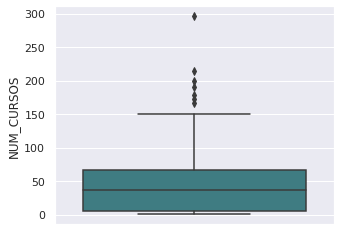

In [7]:
#Visualizando os outliers de número de cursos
sns.set(rc={'figure.figsize':(5,4)})
outliers_num_cursos = sns.boxplot(y="NUM_CURSOS", palette="crest_r", data=df).figure.savefig('outliers_num_cursos')

Tratando Outliers

In [8]:
num_cursos_novo = df['NUM_CURSOS']
Q1 = num_cursos_novo.quantile(.25)
Q3 = num_cursos_novo.quantile(.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ

In [9]:
selecao = (num_cursos_novo >= limite_inferior) & (num_cursos_novo <= limite_superior)
novo_df = df[selecao]
novo_df.head()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
0,114,1,Pública Federal,Centro-Oeste,Mato Grosso,92.0,58.0,44.0,17.0,2.0,0.271930,0.429825,0.938596,0.201754,0.201754
1,149,2,Pública Federal,Centro-Oeste,Distrito Federal,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
2,116,3,Pública Federal,Nordeste,Sergipe,190.0,56.0,94.0,16.0,2.0,0.775862,1.215517,1.793103,0.534483,0.534483
4,100,5,Pública Federal,Nordeste,Piauí,137.0,50.0,73.0,36.0,3.0,4.200000,5.880000,5.880000,2.520000,2.520000
5,55,6,Pública Federal,Sudeste,Minas Gerais,24.0,14.0,31.0,27.0,3.0,4.145455,5.563636,4.872727,2.763636,2.763636


In [10]:
novo_df.describe()

,NUM_CURSOS,CODIGO_IES,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,42.590062,5677.409938,28.049689,15.608696,27.447205,9.006211,1.608696,2.015411,2.454951,2.331534,1.297839,1.297839
std,39.113053,6929.170830,45.790119,34.534254,57.436911,17.243295,3.108806,1.549463,2.177225,1.842168,1.030752,1.030752
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030534,0.022901,0.127273,0.022901,0.022901
25%,6.000000,591.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.700000,0.750000,0.938596,0.450000,0.450000
50%,34.000000,1874.000000,11.000000,5.000000,8.000000,3.000000,0.000000,1.712329,1.770270,1.953846,1.000000,1.000000
75%,59.000000,14408.000000,36.000000,17.000000,30.000000,9.000000,2.000000,3.000000,3.846154,3.342857,2.000000,2.000000
max,150.000000,24672.000000,284.000000,349.000000,351.000000,117.000000,16.000000,6.000000,9.000000,8.000000,4.000000,4.000000


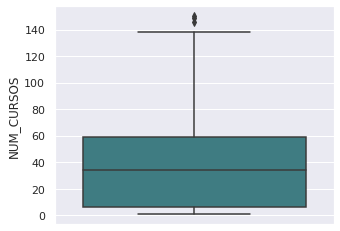

In [11]:
#Visualizando os outliers de número de cursos
sns.set(rc={'figure.figsize':(5,4)})
pos_outliers_num_cursos = sns.boxplot(y='NUM_CURSOS', palette="crest_r", data=novo_df).figure.savefig('pos_outliers_num_cursos')

Alunos com deficiência

In [12]:
#Visualizando os outliers de alunos por deficiência
#deficiencia = pd.DataFrame(data = np.random.random(size=(15,7)), columns = ['DEFICIENCIA_FISICA','DEFICIENCIA_AUDITIVA','DEFICIENCIA_VISUAL','DEFICIENCIA_COGNITIVA','DEFICIENCIA_MULTIPLA'])
#sns.boxplot(x="variable", y="value", data=pd.melt(deficiencia), palette="Blues_r")
#plt.show()

In [13]:
#Tratando outliers no campo de recursos para deficiência física
deficiencia_fisica = df['DEFICIENCIA_FISICA']
Q1 = deficiencia_fisica.quantile(.25)
Q3 = deficiencia_fisica.quantile(.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ

In [14]:
selecao = (deficiencia_fisica >= limite_inferior) & (deficiencia_fisica <= limite_superior)
novo_df = novo_df[selecao]
novo_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
1,149,2,Pública Federal,Centro-Oeste,Distrito Federal,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
5,55,6,Pública Federal,Sudeste,Minas Gerais,24.0,14.0,31.0,27.0,3.0,4.145455,5.563636,4.872727,2.763636,2.763636
6,76,7,Pública Federal,Sudeste,São Paulo,0.0,19.0,5.0,0.0,0.0,1.578947,2.105263,1.842105,1.052632,1.052632
7,84,8,Pública Federal,Sudeste,Minas Gerais,18.0,6.0,15.0,4.0,1.0,2.071429,3.107143,2.761905,1.380952,1.380952
8,58,9,Pública Estadual,Sul,Paraná,18.0,6.0,15.0,13.0,0.0,2.741379,3.672414,2.293103,1.810345,1.810345


In [15]:
#Tratando outliers no campo de recursos para deficiência auditiva
deficiencia_auditiva = df['DEFICIENCIA_AUDITIVA']
Q1 = deficiencia_auditiva.quantile(.25)
Q3 = deficiencia_auditiva.quantile(.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ

In [16]:
selecao = (deficiencia_auditiva >= limite_inferior) & (deficiencia_auditiva <= limite_superior)
novo_df = novo_df[selecao]
novo_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
1,149,2,Pública Federal,Centro-Oeste,Distrito Federal,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
5,55,6,Pública Federal,Sudeste,Minas Gerais,24.0,14.0,31.0,27.0,3.0,4.145455,5.563636,4.872727,2.763636,2.763636
6,76,7,Pública Federal,Sudeste,São Paulo,0.0,19.0,5.0,0.0,0.0,1.578947,2.105263,1.842105,1.052632,1.052632
7,84,8,Pública Federal,Sudeste,Minas Gerais,18.0,6.0,15.0,4.0,1.0,2.071429,3.107143,2.761905,1.380952,1.380952
8,58,9,Pública Estadual,Sul,Paraná,18.0,6.0,15.0,13.0,0.0,2.741379,3.672414,2.293103,1.810345,1.810345


In [17]:
#Tratando outliers no campo de recursos para deficiência visual
deficiencia_visual = df['DEFICIENCIA_VISUAL']
Q1 = deficiencia_visual.quantile(.25)
Q3 = deficiencia_visual.quantile(.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ

In [18]:
selecao = (deficiencia_auditiva >= limite_inferior) & (deficiencia_auditiva <= limite_superior)
novo_df = novo_df[selecao]
novo_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
1,149,2,Pública Federal,Centro-Oeste,Distrito Federal,39.0,32.0,27.0,32.0,8.0,2.778523,4.167785,3.704698,1.852349,1.852349
5,55,6,Pública Federal,Sudeste,Minas Gerais,24.0,14.0,31.0,27.0,3.0,4.145455,5.563636,4.872727,2.763636,2.763636
6,76,7,Pública Federal,Sudeste,São Paulo,0.0,19.0,5.0,0.0,0.0,1.578947,2.105263,1.842105,1.052632,1.052632
7,84,8,Pública Federal,Sudeste,Minas Gerais,18.0,6.0,15.0,4.0,1.0,2.071429,3.107143,2.761905,1.380952,1.380952
8,58,9,Pública Estadual,Sul,Paraná,18.0,6.0,15.0,13.0,0.0,2.741379,3.672414,2.293103,1.810345,1.810345


In [19]:
#Tratando outliers no campo de recursos para deficiência cognitiva
deficiencia_cognitiva = df['DEFICIENCIA_COGNITIVA']
Q1 = deficiencia_cognitiva.quantile(.25)
Q3 = deficiencia_cognitiva.quantile(.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ

In [20]:
selecao = (deficiencia_cognitiva >= limite_inferior) & (deficiencia_cognitiva <= limite_superior)
novo_df = novo_df[selecao]
novo_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
5,55,6,Pública Federal,Sudeste,Minas Gerais,24.0,14.0,31.0,27.0,3.0,4.145455,5.563636,4.872727,2.763636,2.763636
6,76,7,Pública Federal,Sudeste,São Paulo,0.0,19.0,5.0,0.0,0.0,1.578947,2.105263,1.842105,1.052632,1.052632
7,84,8,Pública Federal,Sudeste,Minas Gerais,18.0,6.0,15.0,4.0,1.0,2.071429,3.107143,2.761905,1.380952,1.380952
8,58,9,Pública Estadual,Sul,Paraná,18.0,6.0,15.0,13.0,0.0,2.741379,3.672414,2.293103,1.810345,1.810345
11,64,12,Pública Federal,Sul,Rio Grande do Sul,46.0,21.0,37.0,17.0,0.0,3.937500,5.906250,5.218750,2.625000,2.625000


In [21]:
#Tratando outliers no campo de recursos para deficiência múltipla
deficiencia_multipla = df['DEFICIENCIA_MULTIPLA']
Q1 = deficiencia_multipla.quantile(.25)
Q3 = deficiencia_multipla.quantile(.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ

In [22]:
selecao = (deficiencia_multipla >= limite_inferior) & (deficiencia_multipla <= limite_superior)
novo_df = novo_df[selecao]
novo_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
5,55,6,Pública Federal,Sudeste,Minas Gerais,24.0,14.0,31.0,27.0,3.0,4.145455,5.563636,4.872727,2.763636,2.763636
6,76,7,Pública Federal,Sudeste,São Paulo,0.0,19.0,5.0,0.0,0.0,1.578947,2.105263,1.842105,1.052632,1.052632
7,84,8,Pública Federal,Sudeste,Minas Gerais,18.0,6.0,15.0,4.0,1.0,2.071429,3.107143,2.761905,1.380952,1.380952
8,58,9,Pública Estadual,Sul,Paraná,18.0,6.0,15.0,13.0,0.0,2.741379,3.672414,2.293103,1.810345,1.810345
11,64,12,Pública Federal,Sul,Rio Grande do Sul,46.0,21.0,37.0,17.0,0.0,3.937500,5.906250,5.218750,2.625000,2.625000


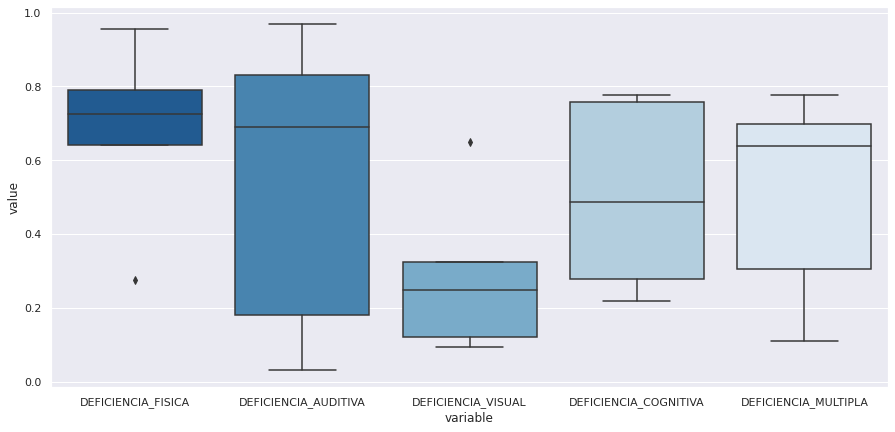

In [23]:
#Visualizando os outliers de alunos por deficiência
sns.set(rc={'figure.figsize':(15,7)})
deficiencia = pd.DataFrame(data = np.random.random(size=(5,5)), columns = ['DEFICIENCIA_FISICA','DEFICIENCIA_AUDITIVA','DEFICIENCIA_VISUAL','DEFICIENCIA_COGNITIVA','DEFICIENCIA_MULTIPLA'])
sns.boxplot(x="variable", y="value", data=pd.melt(deficiencia), palette="Blues_r").figure.savefig('pos_outliers')
plt.show()

##Dados categóricos
Substituindo os dados (tipo de categoria administrativa, regiao e uf) do formato string 

In [24]:
#Substituindo o tipo de categoria administrativa para um código
categoria_adm = {
  "Pública Estadual": 1,
  "Pública Federal": 2,
  "Pública Municipal": 3
}
novo_df.TIPO_CATEGORIA_ADM = novo_df.TIPO_CATEGORIA_ADM.map(categoria_adm)
novo_df.head()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
5,55,6,2,Sudeste,Minas Gerais,24.0,14.0,31.0,27.0,3.0,4.145455,5.563636,4.872727,2.763636,2.763636
6,76,7,2,Sudeste,São Paulo,0.0,19.0,5.0,0.0,0.0,1.578947,2.105263,1.842105,1.052632,1.052632
7,84,8,2,Sudeste,Minas Gerais,18.0,6.0,15.0,4.0,1.0,2.071429,3.107143,2.761905,1.380952,1.380952
8,58,9,1,Sul,Paraná,18.0,6.0,15.0,13.0,0.0,2.741379,3.672414,2.293103,1.810345,1.810345
11,64,12,2,Sul,Rio Grande do Sul,46.0,21.0,37.0,17.0,0.0,3.937500,5.906250,5.218750,2.625000,2.625000


In [25]:
#Substituindo o nome das regiões por códigos
regiao = {
  "Centro-Oeste": 0,
  "Nordeste": 1,
  "Norte": 2,
  "Sudeste": 3,
  "Sul": 4
}
novo_df.REGIAO = novo_df.REGIAO.map(regiao)
novo_df.head()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
5,55,6,2,3,Minas Gerais,24.0,14.0,31.0,27.0,3.0,4.145455,5.563636,4.872727,2.763636,2.763636
6,76,7,2,3,São Paulo,0.0,19.0,5.0,0.0,0.0,1.578947,2.105263,1.842105,1.052632,1.052632
7,84,8,2,3,Minas Gerais,18.0,6.0,15.0,4.0,1.0,2.071429,3.107143,2.761905,1.380952,1.380952
8,58,9,1,4,Paraná,18.0,6.0,15.0,13.0,0.0,2.741379,3.672414,2.293103,1.810345,1.810345
11,64,12,2,4,Rio Grande do Sul,46.0,21.0,37.0,17.0,0.0,3.937500,5.906250,5.218750,2.625000,2.625000


In [26]:
#Substituindo o nome das unidades federativas por códigos
uf = {
  "Acre": 0,
  "Alagoas": 1,
  "Amapá": 2,
  "Amazonas": 3,
  "Bahia": 4,
  "Ceará": 5,
  "Distrito Federal": 6,
  "Espírito Santo": 7,
  "Goiás": 8,
  "Maranhão": 9,
  "Mato Grosso": 10,
  "Mato Grosso do Sul": 11,
  "Minas Gerais": 12,
  "Paraná": 13,
  "Paraíba": 14,
  "Pará": 15,
  "Pernambuco": 16,
  "Piauí": 17,
  "Rio Grande do Norte": 18,
  "Rio Grande do Sul": 19,
  "Rio de Janeiro": 20,
  "Rondônia": 21,
  "Roraima": 22,
  "Santa Catarina": 23,
  "Sergipe": 24,
  "São Paulo": 25,
  "Tocantins": 26
  }
novo_df.UF = novo_df.UF.map(uf)
novo_df.head()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
5,55,6,2,3,12,24.0,14.0,31.0,27.0,3.0,4.145455,5.563636,4.872727,2.763636,2.763636
6,76,7,2,3,25,0.0,19.0,5.0,0.0,0.0,1.578947,2.105263,1.842105,1.052632,1.052632
7,84,8,2,3,12,18.0,6.0,15.0,4.0,1.0,2.071429,3.107143,2.761905,1.380952,1.380952
8,58,9,1,4,13,18.0,6.0,15.0,13.0,0.0,2.741379,3.672414,2.293103,1.810345,1.810345
11,64,12,2,4,19,46.0,21.0,37.0,17.0,0.0,3.937500,5.906250,5.218750,2.625000,2.625000


In [27]:
novo_df.describe()

,NUM_CURSOS,CODIGO_IES,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,32.744186,6637.759690,1.604651,2.589147,17.271318,13.333333,6.108527,15.565891,3.906977,0.550388,1.844061,2.153059,2.034221,1.183949,1.183949
std,31.320989,7303.802647,0.617690,1.072471,7.596002,18.320640,8.658666,42.366305,5.749242,0.999697,1.504790,2.041875,1.714380,0.997931,0.997931
min,1.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030534,0.022901,0.127273,0.022901,0.022901
25%,4.000000,605.000000,1.000000,2.000000,12.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.545455,0.545455,0.750000,0.400000,0.400000
50%,25.000000,3279.000000,2.000000,3.000000,19.000000,5.000000,3.000000,4.000000,2.000000,0.000000,1.500000,1.500000,1.636364,1.000000,1.000000
75%,54.000000,15520.000000,2.000000,3.000000,25.000000,17.000000,8.000000,15.000000,5.000000,1.000000,2.777778,3.107143,2.666667,1.857143,1.857143
max,131.000000,24672.000000,3.000000,4.000000,26.000000,81.000000,43.000000,332.000000,27.000000,5.000000,6.000000,9.000000,8.000000,4.000000,4.000000


##Matriz de Correlação

In [28]:
#Usando matriz de correlação
matriz_corr = df.corr()
matriz_corr

,NUM_CURSOS,CODIGO_IES,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
NUM_CURSOS,1.000000,-0.480660,0.483570,0.271308,0.358844,0.503810,0.442508,-0.076056,0.016663,0.026430,-0.057398,-0.057398
CODIGO_IES,-0.480660,1.000000,-0.311680,-0.221917,-0.253225,-0.261333,-0.264941,-0.002603,-0.092910,-0.108087,-0.017777,-0.017777
DEFICIENCIA_FISICA,0.483570,-0.311680,1.000000,0.373157,0.520917,0.616079,0.471765,0.198019,0.246029,0.292028,0.188640,0.188640
DEFICIENCIA_AUDITIVA,0.271308,-0.221917,0.373157,1.000000,0.306801,0.300199,0.235363,0.278242,0.319987,0.361998,0.283392,0.283392
DEFICIENCIA_VISUAL,0.358844,-0.253225,0.520917,0.306801,1.000000,0.590417,0.465864,0.290336,0.348050,0.381587,0.300004,0.300004
DEFICIENCIA_COGNITIVA,0.503810,-0.261333,0.616079,0.300199,0.590417,1.000000,0.563351,0.211004,0.267263,0.285733,0.218657,0.218657
DEFICIENCIA_MULTIPLA,0.442508,-0.264941,0.471765,0.235363,0.465864,0.563351,1.000000,0.068154,0.106196,0.146138,0.071012,0.071012
RECURSOS_DEF_FISICA,-0.076056,-0.002603,0.198019,0.278242,0.290336,0.211004,0.068154,1.000000,0.945914,0.927598,0.992957,0.992957
RECURSOS_DEF_VISUAL,0.016663,-0.092910,0.246029,0.319987,0.348050,0.267263,0.106196,0.945914,1.000000,0.953901,0.950328,0.950328
RECURSOS_DEF_AUDITIVA,0.026430,-0.108087,0.292028,0.361998,0.381587,0.285733,0.146138,0.927598,0.953901,1.000000,0.931386,0.931386


In [29]:
#Observando a correlação entre os dados
from biokit.viz import corrplot

Creating directory /root/.config/biokit 
Creating directory /root/.config/bioservices 


/usr/local/lib/python3.7/dist-packages/biokit/viz/linkage.py:41: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/usr/local/lib/python3.7/dist-packages/biokit/viz/corrplot.py:335: MatplotlibDeprecationWarning:


The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.



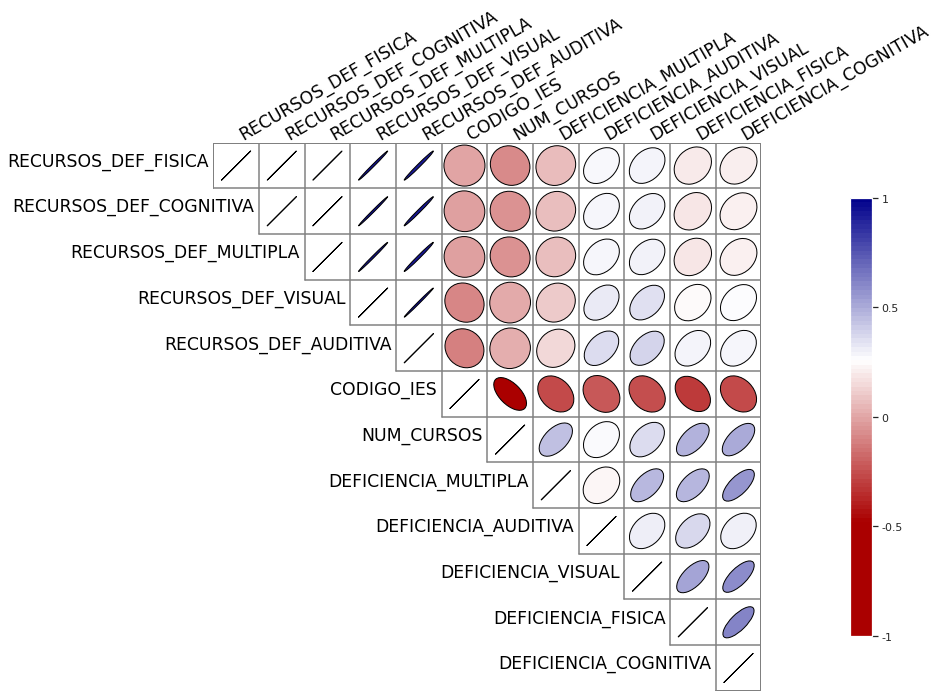

<Figure size 1800x720 with 0 Axes>

In [ ]:
sns.set(rc={'figure.figsize':(25,10)})
corr_graf = corrplot.Corrplot(matriz_corr)
corr_graf.plot(upper = 'ellipse', fontsize = 'x-large')
plt.gcf()
matriz_correlacao = plt.figure()
matriz_correlacao.savefig('matriz_correlacao')
matriz_correlacao.show()

##Normalização

In [30]:
novo_df.columns

Index(['NUM_CURSOS', 'CODIGO_IES', 'TIPO_CATEGORIA_ADM', 'REGIAO', 'UF',
       'DEFICIENCIA_FISICA', 'DEFICIENCIA_AUDITIVA', 'DEFICIENCIA_VISUAL',
       'DEFICIENCIA_COGNITIVA', 'DEFICIENCIA_MULTIPLA', 'RECURSOS_DEF_FISICA',
       'RECURSOS_DEF_VISUAL', 'RECURSOS_DEF_AUDITIVA',
       'RECURSOS_DEF_COGNITIVA', 'RECURSOS_DEF_MULTIPLA'],
      dtype='object')

In [31]:
#Colunas para normalizar
features_to_normalize = ['NUM_CURSOS','DEFICIENCIA_FISICA', 'DEFICIENCIA_AUDITIVA', 'DEFICIENCIA_VISUAL','DEFICIENCIA_COGNITIVA', 'DEFICIENCIA_MULTIPLA', 'RECURSOS_DEF_FISICA', 'RECURSOS_DEF_VISUAL', 'RECURSOS_DEF_AUDITIVA', 'RECURSOS_DEF_COGNITIVA', 'RECURSOS_DEF_MULTIPLA']

novo_df[features_to_normalize] = novo_df[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

In [32]:
#Dataframe normalizado
novo_df = novo_df[['NUM_CURSOS','TIPO_CATEGORIA_ADM', 'REGIAO', 'UF', 'DEFICIENCIA_FISICA', 'DEFICIENCIA_AUDITIVA', 'DEFICIENCIA_VISUAL','DEFICIENCIA_COGNITIVA', 'DEFICIENCIA_MULTIPLA', 'RECURSOS_DEF_FISICA', 'RECURSOS_DEF_VISUAL', 'RECURSOS_DEF_AUDITIVA', 'RECURSOS_DEF_COGNITIVA', 'RECURSOS_DEF_MULTIPLA']]
novo_df.head()

,NUM_CURSOS,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
5,0.415385,2,3,12,0.296296,0.325581,0.093373,1.000000,0.6,0.689328,0.617208,0.602771,0.689129,0.689129
6,0.576923,2,3,25,0.000000,0.441860,0.015060,0.000000,0.0,0.259389,0.231964,0.217819,0.258915,0.258915
7,0.638462,2,3,12,0.222222,0.139535,0.045181,0.148148,0.2,0.341889,0.343568,0.334653,0.341468,0.341468
8,0.438462,1,4,13,0.222222,0.139535,0.045181,0.481481,0.0,0.454119,0.406536,0.275106,0.449434,0.449434
11,0.484615,2,4,19,0.567901,0.488372,0.111446,0.629630,0.0,0.654492,0.655373,0.646723,0.654271,0.654271


#Clustering

##1- Usando o K-means

In [33]:
from sklearn.cluster import KMeans

In [34]:
novo_df.head()

,NUM_CURSOS,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
5,0.415385,2,3,12,0.296296,0.325581,0.093373,1.000000,0.6,0.689328,0.617208,0.602771,0.689129,0.689129
6,0.576923,2,3,25,0.000000,0.441860,0.015060,0.000000,0.0,0.259389,0.231964,0.217819,0.258915,0.258915
7,0.638462,2,3,12,0.222222,0.139535,0.045181,0.148148,0.2,0.341889,0.343568,0.334653,0.341468,0.341468
8,0.438462,1,4,13,0.222222,0.139535,0.045181,0.481481,0.0,0.454119,0.406536,0.275106,0.449434,0.449434
11,0.484615,2,4,19,0.567901,0.488372,0.111446,0.629630,0.0,0.654492,0.655373,0.646723,0.654271,0.654271


In [35]:
#Agrupando em 3 grupos
agrupador = KMeans(n_clusters = 3)
agrupador.fit(novo_df)

KMeans(n_clusters=3)

In [36]:
labels = agrupador.labels_
print(labels)

[0 1 0 0 1 2 1 1 0 2 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 2 2 1 1 0 2 1 1
 1 2 1 0 1 2 1 1 0 1 0 2 1 1 1 2 2 2 0 1 2 0 1 1 1 1 0 0 1 2 0 1 1 1 1 1 1
 0 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 0 0 1 2 2 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 0 0 2 2 1 1 1 0 2 1 1]


In [43]:
#Visualizando os clusters
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['RECURSOS_DEF_FISICA'], y=df['DEFICIENCIA_FISICA'], 
                         mode = 'markers',
                         marker = dict(color = agrupador.labels_.astype(np.float)),
                         text = labels))
fig.show()

In [ ]:
#Visualização em três dimensões
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df['DEFICIENCIA_VISUAL'],
                          y=df['RECURSOS_DEF_VISUAL'],
                          z=df['TIPO_CATEGORIA_ADM'],
                          mode = 'markers',
                          marker = dict(color = agrupador.labels_.astype(np.float)),
                          text = labels))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df['DEFICIENCIA_VISUAL'],
                          y=df['RECURSOS_DEF_VISUAL'],
                          z=df['NUM_CURSOS'],
                          mode = 'markers',
                          marker = dict(color = agrupador.labels_.astype(np.float)),
                          text = labels))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df['DEFICIENCIA_VISUAL'],
                          y=df['RECURSOS_DEF_VISUAL'],
                          z=df['UF'],
                          mode = 'markers',
                          marker = dict(color = agrupador.labels_.astype(np.float)),
                          text = labels))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=df['DEFICIENCIA_VISUAL'],
                          y=df['RECURSOS_DEF_VISUAL'],
                          z=df['REGIAO'],
                          mode = 'markers',
                          marker = dict(color = agrupador.labels_.astype(np.float)),
                          text = labels))
fig.show()

##2 - Usando o DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
agrupador = DBSCAN(eps = 1.31,
                   min_samples = 10,
                   metric = 'euclidean')
agrupador.fit(novo_df)

DBSCAN(eps=1.31, min_samples=10)

In [ ]:
#Visualizando o número total de clusters
np.unique(agrupador.labels_)

array([-1,  0,  1])

In [ ]:
#Quando reduzimos muito o epsilon, todos os dados são consideradas ruídos. Para se organizar em clusters é necessário um número mínimo de 15 vizinhos.
agrupador = DBSCAN(eps=3, min_samples = 15, metric = 'euclidean')

# Observações: eps é a máxima distância entre os pontos/ mínimo de pontos é igual a 10/ a métrica de distância considerada'manhattan'
agrupador.fit(novo_df)
agrupador.labels_

array([ 0,  1,  0,  0,  1, -1,  1,  1,  0, -1,  1,  0,  1,  1,  0, -1,  0,
        0, -1,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0, -1, -1,  1,  1,  0,
       -1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  0, -1,  1,  1,
        1, -1, -1, -1,  0,  1, -1, -1,  1,  1,  1,  1,  0,  0,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  0,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1,  0,  0,  1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  0,
        0, -1, -1,  1,  1,  1,  0, -1,  1,  1])

Muita dificuldade em usar o DBScan, principalmente por causa da definição dos parâmetros a serem utilizados.

##3 - Usando o K-modes

In [47]:
#Instalando o k-modes
!pip install kmodes

In [48]:
# Fazendo o upgrade da última versão (recomendado)
!pip install --upgrade kmodes

In [49]:
#Importando bibliotecas
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
#Construindo um modelo com 3 clusters
kmode = KModes(n_clusters=3, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(novo_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20, cost: 1217.0
Run 1, iteration: 2/100, moves: 1, cost: 1217.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 26, cost: 1235.0
Run 2, iteration: 2/100, moves: 8, cost: 1235.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 23, cost: 1238.0
Run 3, iteration: 2/100, moves: 5, cost: 1236.0
Run 3, iteration: 3/100, moves: 0, cost: 1236.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 25, cost: 1222.0
Run 4, iteration: 2/100, moves: 1, cost: 1222.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 23, cost: 1220.0
Run 5, iteration: 2/100, moves: 1, cost: 1220.0
Best run was number 1


array([0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 0, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 0, 2, 0, 1, 0, 2, 0, 0, 1,
       0, 0, 0, 1, 2, 0, 2, 1, 0, 1, 2, 2, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 2, 0, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1],
      dtype=uint16)

In [51]:
novo_df.insert(0, "Cluster", clusters, True)
novo_df

,Cluster,NUM_CURSOS,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
5,0,0.415385,2,3,12,0.296296,0.325581,0.093373,1.000000,0.6,0.689328,0.617208,0.602771,0.689129,0.689129
6,1,0.576923,2,3,25,0.000000,0.441860,0.015060,0.000000,0.0,0.259389,0.231964,0.217819,0.258915,0.258915
7,0,0.638462,2,3,12,0.222222,0.139535,0.045181,0.148148,0.2,0.341889,0.343568,0.334653,0.341468,0.341468
8,1,0.438462,1,4,13,0.222222,0.139535,0.045181,0.481481,0.0,0.454119,0.406536,0.275106,0.449434,0.449434
11,2,0.484615,2,4,19,0.567901,0.488372,0.111446,0.629630,0.0,0.654492,0.655373,0.646723,0.654271,0.654271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,1,0.007692,1,3,25,0.012346,0.000000,0.000000,0.000000,0.0,0.246164,0.108844,0.174365,0.245681,0.245681
2522,1,0.015385,3,4,13,0.000000,0.000000,0.003012,0.000000,0.0,0.329923,0.220238,0.195535,0.329495,0.329495
2598,1,0.138462,1,1,9,0.012346,0.000000,0.006024,0.000000,0.0,0.021335,0.032626,0.030631,0.033943,0.033943
2605,1,0.000000,1,3,25,0.012346,0.000000,0.000000,0.000000,0.0,0.329923,0.220238,0.237875,0.245681,0.245681


In [52]:
cluster_0 = novo_df.loc[novo_df['Cluster'] == 0]
cluster_0.head()

,Cluster,NUM_CURSOS,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
5,0,0.415385,2,3,12,0.296296,0.325581,0.093373,1.000000,0.6,0.689328,0.617208,0.602771,0.689129,0.689129
7,0,0.638462,2,3,12,0.222222,0.139535,0.045181,0.148148,0.2,0.341889,0.343568,0.334653,0.341468,0.341468
40,0,0.669231,1,4,13,0.370370,0.581395,1.000000,0.222222,0.2,0.908626,0.908859,0.907621,0.908567,0.908567
278,0,0.807692,2,3,12,0.827160,0.651163,0.135542,0.888889,0.0,0.593845,0.538658,0.465554,0.594376,0.594376
279,0,0.800000,2,3,12,0.901235,0.813953,0.102410,0.518519,0.0,0.524565,0.456819,0.445947,0.528252,0.528252


In [53]:
cluster_0.shape

(42, 15)

In [54]:
cluster_1 = novo_df.loc[novo_df['Cluster'] == 1]
cluster_1.head()

,Cluster,NUM_CURSOS,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
6,1,0.576923,2,3,25,0.000000,0.441860,0.015060,0.000000,0.0,0.259389,0.231964,0.217819,0.258915,0.258915
8,1,0.438462,1,4,13,0.222222,0.139535,0.045181,0.481481,0.0,0.454119,0.406536,0.275106,0.449434,0.449434
22,1,0.292308,1,1,4,0.037037,0.000000,0.009036,0.074074,0.0,0.123746,0.125981,0.114111,0.123185,0.123185
30,1,0.046154,1,3,25,0.074074,0.069767,0.000000,0.000000,0.0,0.449580,0.299806,0.219729,0.461201,0.461201
32,1,0.046154,1,3,25,0.012346,0.000000,0.015060,0.148148,0.0,0.138473,0.188411,0.147146,0.102002,0.102002


In [55]:
cluster_1.shape

(63, 15)

In [56]:
cluster_2 = novo_df.loc[novo_df['Cluster'] == 2]
cluster_2.head()

,Cluster,NUM_CURSOS,TIPO_CATEGORIA_ADM,REGIAO,UF,DEFICIENCIA_FISICA,DEFICIENCIA_AUDITIVA,DEFICIENCIA_VISUAL,DEFICIENCIA_COGNITIVA,DEFICIENCIA_MULTIPLA,RECURSOS_DEF_FISICA,RECURSOS_DEF_VISUAL,RECURSOS_DEF_AUDITIVA,RECURSOS_DEF_COGNITIVA,RECURSOS_DEF_MULTIPLA
11,2,0.484615,2,4,19,0.567901,0.488372,0.111446,0.629630,0.0,0.654492,0.655373,0.646723,0.654271,0.654271
34,2,1.000000,1,1,4,0.209877,0.302326,0.090361,0.407407,0.4,0.000000,0.000000,0.013892,0.000000,0.000000
50,2,0.407692,3,4,23,0.148148,0.255814,0.036145,0.111111,0.6,0.512953,0.455404,0.440168,0.511090,0.511090
282,2,0.953846,2,1,14,0.617284,0.604651,0.984940,0.074074,1.0,0.675683,0.673837,0.672794,0.674134,0.674134
302,2,0.369231,2,1,4,0.296296,0.209302,0.036145,0.333333,0.0,0.319667,0.329359,0.333789,0.322653,0.322653


In [57]:
cluster_2.shape

(24, 15)

##4 - Usando o K-prototypes

In [58]:
#Alternatively, you can build the latest development version from source:
#git clone https://github.com/nicodv/kmodes.git
#cd kmodes
#python setup.py install

In [59]:
#K-Prototypes
kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2)
clusters = kproto.fit_predict(novo_df, categorical=[1,2,3])

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 7, ncost: 897.0701859723321
Run: 1, iteration: 2/100, moves: 2, ncost: 895.1610666101664
Run: 1, iteration: 3/100, moves: 0, ncost: 895.1610666101664
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 26, ncost: 1098.6270669221014
Run: 2, iteration: 2/100, moves: 14, ncost: 895.0841322604006
Run: 2, iteration: 3/100, moves: 0, ncost: 895.0841322604006
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 36, ncost: 988.6117574554028
Run: 3, iteration: 2/100, moves: 13, ncost: 904.2204461584947
Run: 3, iteration: 3/100, moves: 3, ncost: 897.3284415520337
Run: 3, iteration: 4/100, moves: 2, ncost: 895.419322189868
Run: 3, iteration: 5/100, moves:

In [60]:
#Centróides do modelo treinado
print(kproto.cluster_centroids_)

[[6.12903226e-01 1.30645161e+01 2.46515333e-01 2.35558890e-01
  1.09405363e-01 2.42532855e-01 1.29032258e-01 3.34590270e-01
  2.95452860e-01 2.98811540e-01 3.32255148e-01 3.32255148e-01
  2.76923077e-01 2.00000000e+00 3.00000000e+00]
 [5.60000000e-01 1.96400000e+01 2.64197531e-01 2.02790698e-01
  4.93975904e-02 1.89629630e-01 1.76000000e-01 2.99969162e-01
  2.26262977e-01 2.76377412e-01 2.82871343e-01 2.82871343e-01
  0.00000000e+00 2.00000000e+00 3.00000000e+00]
 [9.59183673e-01 2.47755102e+01 6.92869740e-02 5.79022307e-02
  1.37078928e-02 4.30839002e-02 4.48979592e-02 3.30200663e-01
  2.37234387e-01 2.06929369e-01 3.13103415e-01 3.13103415e-01
  2.30769231e-02 1.00000000e+00 3.00000000e+00]
 [1.29166667e+00 4.91666667e+00 1.49691358e-01 1.29844961e-01
  3.12500000e-02 1.79012346e-01 1.50000000e-01 2.14120927e-01
  1.73752171e-01 2.05604916e-01 2.06068244e-01 2.06068244e-01
  1.38461538e-01 2.00000000e+00 1.00000000e+00]]


In [61]:
#Training statistics
print(kproto.cost_)
print(kproto.n_iter_)

895.0841322604006
3


In [62]:
#Contagem de cada cluster
pd.Series(clusters).value_counts()

2    49
0    31
1    25
3    24
dtype: int64

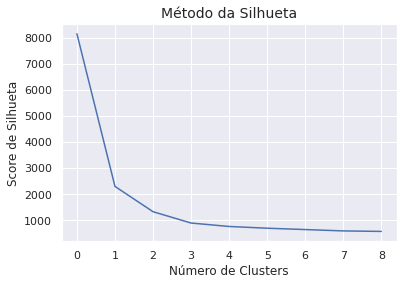

In [63]:
#Coeficiente de Silhueta
#Verificando melhor número de clusters
cost = []
for num_clusters in list(range(1,10)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(novo_df, categorical=[1,2,3])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.title('Método da Silhueta', fontsize=14)
plt.xlabel("Número de Clusters", fontsize=12)
plt.ylabel("Score de Silhueta", fontsize=12)
plt.savefig('silhueta.png')